# Import Libraries

In [1]:
import pandas as pd 
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
%matplotlib inline
import pandas as pd 
from tabulate import tabulate
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [93]:
train1 = pd.read_csv('train_month_3_with_target.csv')
train2 = pd.read_csv('train_month_2.csv')
train3 = pd.read_csv('train_month_1.csv')
test1 = pd.read_csv('test_month_3.csv')
test2 = pd.read_csv('test_month_2.csv')
test3 = pd.read_csv('test_month_1.csv')

# Define functions

# Data pre-processing

## Dataset Cleaning

In [3]:
#train1.info()
train1.describe()
train1.isna().any()
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63697 entries, 0 to 63696
Data columns (total 40 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   client_id                          63697 non-null  object 
 1   homebanking_active                 63697 non-null  int64  
 2   has_homebanking                    63697 non-null  int64  
 3   has_insurance_21                   63697 non-null  int64  
 4   has_insurance_23                   63697 non-null  int64  
 5   has_life_insurance_fixed_cap       63697 non-null  int64  
 6   has_life_insurance_decreasing_cap  63697 non-null  int64  
 7   has_fire_car_other_insurance       63697 non-null  int64  
 8   has_personal_loan                  63697 non-null  int64  
 9   has_mortgage_loan                  63697 non-null  int64  
 10  has_current_account                63697 non-null  int64  
 11  has_pension_saving                 63697 non-null  int

In [4]:
train1['customer_since_all'] = pd.to_datetime(train1['customer_since_all'])
train1['customer_since_bank'] = pd.to_datetime(train1['customer_since_bank'])
train1['customer_birth_date'] = pd.to_datetime(train1['customer_birth_date'])

cat_vars = []
cont_vars = []
columns = list(train1.drop(columns = ['client_id']).columns)
for i in columns:
    if (len(train1.loc[:,i].unique()) >= 20):
        cont_vars.append(i)
    else:
        cat_vars.append(i)
        
print('Continious variables are:',cont_vars)
print('------------------')
print('Categorical variables are:',cat_vars)
# Here we have our list of categorical and continious variables

Continious variables are: ['bal_insurance_21', 'bal_insurance_23', 'cap_life_insurance_fixed_cap', 'cap_life_insurance_decreasing_cap', 'prem_fire_car_other_insurance', 'bal_personal_loan', 'bal_mortgage_loan', 'bal_current_account', 'bal_pension_saving', 'bal_savings_account', 'bal_savings_account_starter', 'bal_current_account_starter', 'customer_since_all', 'customer_since_bank', 'customer_birth_date', 'customer_postal_code']
------------------
Categorical variables are: ['homebanking_active', 'has_homebanking', 'has_insurance_21', 'has_insurance_23', 'has_life_insurance_fixed_cap', 'has_life_insurance_decreasing_cap', 'has_fire_car_other_insurance', 'has_personal_loan', 'has_mortgage_loan', 'has_current_account', 'has_pension_saving', 'has_savings_account', 'has_savings_account_starter', 'has_current_account_starter', 'visits_distinct_so', 'visits_distinct_so_areas', 'customer_gender', 'customer_occupation_code', 'customer_self_employed', 'customer_education', 'customer_children', 

### Categorical features unique values - checking consistency

In [5]:
# To check we will print all unique values
for col in cat_vars:
    print(col,train1[col].unique())

homebanking_active [0 1]
has_homebanking [0 1]
has_insurance_21 [0 1]
has_insurance_23 [0 1]
has_life_insurance_fixed_cap [0 1]
has_life_insurance_decreasing_cap [0 1]
has_fire_car_other_insurance [1 0]
has_personal_loan [0 1]
has_mortgage_loan [0 1]
has_current_account [1 0]
has_pension_saving [0 1]
has_savings_account [1 0]
has_savings_account_starter [0 1]
has_current_account_starter [0 1]
visits_distinct_so [1. 2. 3. 4. 6. 5. 7.]
visits_distinct_so_areas [1. 2. 3. 5. 4. 6.]
customer_gender [1 2]
customer_occupation_code [ 9. nan  7.  8.  4.  5.  0.  6.  3.  1.  2.]
customer_self_employed [0 1]
customer_education [ 0. nan  2.  1.  4.  3.  5.  6.]
customer_children [nan 'mature' 'no' 'young' 'preschool' 'adolescent' 'grownup' 'onebaby'
 'yes']
customer_relationship [nan 'couple' 'single']
target [0 1]


In [6]:
# looks good, should transform into categorical

### Missing Data

In [7]:
missing_df = train1.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['%']=(missing_df['missing values'])/train1.shape[0]*100
missing_df = missing_df[missing_df['missing values'] >0].sort_values('%')
missing_df

,variable,missing values,%
29,customer_since_all,234,0.367364
30,customer_since_bank,249,0.390913
34,customer_occupation_code,2002,3.143005
38,customer_relationship,14899,23.390427
37,customer_children,23364,36.679906
36,customer_education,47125,73.983076


In [8]:
missing_df = train2.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['%']=(missing_df['missing values'])/train1.shape[0]*100
missing_df = missing_df[missing_df['missing values'] >0].sort_values('%')
missing_df

,variable,missing values,%
29,customer_since_all,234,0.367364
30,customer_since_bank,249,0.390913
34,customer_occupation_code,2002,3.143005
38,customer_relationship,14476,22.726345
37,customer_children,23065,36.210497
36,customer_education,47125,73.983076


In [9]:
missing_df = train3.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['%']=(missing_df['missing values'])/train1.shape[0]*100
missing_df = missing_df[missing_df['missing values'] >0].sort_values('%')
missing_df

,variable,missing values,%
29,customer_since_all,234,0.367364
30,customer_since_bank,249,0.390913
34,customer_occupation_code,2002,3.143005
38,customer_relationship,14456,22.694946
37,customer_children,23056,36.196367
36,customer_education,47125,73.983076


In [10]:
for x in ['customer_since_all','customer_since_bank','customer_occupation_code','customer_relationship',
         'customer_children','customer_education']:
    print(str(x) + ": " + str(train2.loc[train1[x].isna(),x].value_counts().sum()))
    print(str(x) + ": " + str(train3.loc[train1[x].isna(),x].value_counts().sum()))
    print("-----------------------------------------")

customer_since_all: 0
customer_since_all: 0
-----------------------------------------
customer_since_bank: 0
customer_since_bank: 0
-----------------------------------------
customer_occupation_code: 0
customer_occupation_code: 0
-----------------------------------------
customer_relationship: 1000
customer_relationship: 1015
-----------------------------------------
customer_children: 977
customer_children: 984
-----------------------------------------
customer_education: 0
customer_education: 0
-----------------------------------------


In [11]:
# Fix customer relationship and customer children
train1['customer_children2'] = train2['customer_children']
train1['customer_children3'] = train3['customer_children']

train1.customer_children = np.where(train1.customer_children.isnull(), train1.customer_children2, train1.customer_children)
train1.customer_children = np.where(train1.customer_children.isnull(), train1.customer_children3, train1.customer_children)


train1['customer_relationship2'] = train2['customer_relationship']
train1['customer_relationship3'] = train3['customer_relationship']

train1.customer_relationship = np.where(train1.customer_relationship.isnull(), train1.customer_relationship2, train1.customer_relationship)
train1.customer_relationship = np.where(train1.customer_relationship.isnull(), train1.customer_relationship3, train1.customer_relationship)

train1 = train1.drop(columns = ['customer_relationship2','customer_relationship3',
                                'customer_children2','customer_children3'])

In [12]:
missing_df = train1.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['%']=(missing_df['missing values'])/train1.shape[0]*100
missing_df = missing_df[missing_df['missing values'] >0].sort_values('%')
missing_df

,variable,missing values,%
29,customer_since_all,234,0.367364
30,customer_since_bank,249,0.390913
34,customer_occupation_code,2002,3.143005
38,customer_relationship,13884,21.796945
37,customer_children,22380,35.135093
36,customer_education,47125,73.983076


In [13]:
# We will drop columns with missing customer_since_all and customer_since_bank since they are very few variables

In [14]:
df_list=[train1,train2,train3,test1,test2,test3]

In [15]:
def drop_col(x):
    x.drop(x[x['customer_since_all'].isna()].index,inplace = True)
    x.drop(x[x['customer_since_bank'].isna()].index,inplace = True)

In [16]:
for x in df_list:
    drop_col(x)

Before we do anything with any of the columns with remainder of the missing values, we will select features

### hide temp explore

In [17]:
# sns.countplot(x='customer_education',data=train1,hue='target',palette="coolwarm_r")

In [18]:
# for x in range(0,10):
#     print(f'job_code {x}', len(train1.loc[(train1['customer_occupation_code']==x)]))
    
# sns.histplot(x='customer_occupation_code',data=train1,hue='target',palette="coolwarm_r")

In [19]:
# sns.histplot(x='customer_occupation_code',data=train1,hue='target',palette="coolwarm_r",multiple = "fill")

In [20]:


# a = len(train1.loc[(train1['customer_relationship']=='couple') & (train1['target']== 0)])+len(train1.loc[(train1['customer_relationship']=='couple') & (train1['target']== 1)]) 

# b = len(train1.loc[(train1['customer_relationship']=='single') & (train1['target']== 0)])+ len(train1.loc[(train1['customer_relationship']=='single') & (train1['target']== 1)]) 
# table=[['Relationship','0','1'],
#         [str(len(train1.loc[(train1['customer_relationship']=='couple')])) + ' Couple',round(len(train1.loc[(train1['customer_relationship']=='couple') & (train1['target']== 0)])/a,3 ),round(len(train1.loc[(train1['customer_relationship']=='couple') & (train1['target']== 1)])/a,3) ],
#         [str(len(train1.loc[(train1['customer_relationship']=='single')])) + ' Single',round(len(train1.loc[(train1['customer_relationship']=='single') & (train1['target']== 0)])/b,3) ,round(len(train1.loc[(train1['customer_relationship']=='single') & (train1['target']== 1)])/b,3) ]]
# print(tabulate(table, headers='firstrow'))



In [21]:
# rep = {'mature':1,'no':0, 'young':1,'preschool':1,'adolescent':1,'grownup':1,'onebaby':1
#  ,'yes':1}
# train1['customer_children']= train1['customer_children'].replace(rep) 

In [22]:
# c = len(train1.loc[(train1['customer_children']==0) & (train1['target']== 0)])+len(train1.loc[(train1['customer_children']==0) & (train1['target']== 1)]) 

# d = len(train1.loc[(train1['customer_children']==1) & (train1['target']== 0)])+ len(train1.loc[(train1['customer_children']==1) & (train1['target']== 1)]) 
# table=[['Children','0','1'],
#         [str(len(train1.loc[(train1['customer_children']==0)])) + ' Without kids',round(len(train1.loc[(train1['customer_children']==0) & (train1['target']== 0)])/c,2 ),round(len(train1.loc[(train1['customer_children']==0) & (train1['target']== 1)])/c,2) ],
#         [str(len(train1.loc[(train1['customer_children']==1)])) + ' With kids',round(len(train1.loc[(train1['customer_children']==1) & (train1['target']== 0)])/d,2) ,round(len(train1.loc[(train1['customer_children']==1) & (train1['target']== 1)])/d,2) ]]
# print(tabulate(table, headers='firstrow'))

In [23]:
# train1['customer_children'] = pd.Categorical(train1['customer_children'])
# sns.histplot(x='customer_children',data=train1,hue='target',palette="coolwarm_r")

In [24]:
# plot = sns.histplot(x='customer_children',data=train1,hue='target',palette="coolwarm_r",multiple = "fill")
# plot.set(ylim=(0,0.06))

In [25]:
# thjis var seems useful what do we do about missing values

In [26]:
# train1_test = train1.copy()
# # train1_test['customer_children'].isna()
# train1_test['customer_children'] = pd.to_numeric(train1_test['customer_children'])
# train1_test.loc[train1_test['customer_children'].isna(),'customer_children'] = 2

In [27]:
# train1_test['customer_children'].replace({0:'no children',1:'children',2:'missing'})
# train1_test['customer_children'] = pd.Categorical(train1_test['customer_children'])

In [28]:
# plot = sns.histplot(x='customer_children',data=train1_test,hue='target',palette="coolwarm_r",multiple = "fill")
# plot.set(ylim=(0,0.06))

## Create date column

In [29]:
def striptime(x):
    x['customer_since_all'] = pd.to_datetime(x['customer_since_all'])
    x['customer_since_bank'] = pd.to_datetime(x['customer_since_bank'])
    x['customer_birth_date'] = pd.to_datetime(x['customer_birth_date'])
    x['Birth_year'] = x['customer_birth_date'].dt.strftime('%Y').astype(str).astype(int)
    x['Year_since_all'] = x['customer_since_all'].dt.strftime('%Y').astype(str).astype(int)
    x['Year_since_bank'] = x['customer_since_bank'].dt.strftime('%Y').astype(str).astype(int)
    x.drop(['customer_since_all','customer_since_bank','customer_birth_date'], axis=1, inplace=True)

In [30]:
# def drop_col(x):
#     x.drop(['customer_children','customer_relationship','customer_occupation_code',
#             'customer_education',],axis=1, inplace=True) 
#     x.dropna(axis=0, inplace=True) 

In [31]:
for x in df_list:
    x = striptime(x)
#     print(x.shape)

## Feature Engineering

### Create Age variables

First, let's extract the customer's Age and drop Birth_year

In [32]:
def client_age(x):
    x['Age'] = x['Birth_year'].apply(lambda x: 2018 -x)
for x in df_list:
    client_age(x)

- We could see if there is a significant (large) difference in say balance or savings as this could be an indicator that the client is about to churn. (can just be stored as a boolean). 
- can also compute a boolean regarding the change in some services that the client has. Say he dropped in insurrance 21 last month or smtg. also as a boolean 

### Removing outliers based on Birth year/Age

We have noticed some of the clients are born in the 80s. Therefore we will assign a threshhold of 100years for the client's age.  In addition, the client's birth year cannot greater than the year he started using the banks services.

In [33]:
def remove_out(x):
    x.drop(x[x['Birth_year'] < 1919].index, inplace = True)
    x.drop(x.loc[x['Birth_year'] > (x['Year_since_all'] | x['Year_since_bank'])].index, inplace=True)

In [34]:
for x in df_list:
    remove_out(x)
    x.drop(x.loc[(x['customer_children'] =="preschool") & (x['Age'] <21  )].index, inplace=True)
    x.drop(x.loc[(x['customer_children'] =="young") & (x['Age'] <28  )].index, inplace=True)
    x.drop(x.loc[(x['customer_children'] =="adolescent") & (x['Age'] <32  )].index, inplace=True)
    x.drop(x.loc[(x['customer_children'] =="grownup") & (x['Age'] <36  )].index, inplace=True)
    x.drop(x.loc[(x['customer_children'] =="mature") & (x['Age'] <42 )].index, inplace = True)

### Create client since variable

In [35]:
def client_since(x):
    x['Year_since_all'] = x['Year_since_all'].apply(lambda x: 2018 -x)
    x['Year_since_bank'] = x['Year_since_bank'].apply(lambda x: 2018 -x)
    
for x in df_list:
    client_since(x)

### Create difference variables

In [36]:
#creates a new column in the dataset with a boolean regarding if the values between the 3 columns are the same. 

def change(orig1,orig2,orig3, cols_bool,cols_cont,key ='client_id'):
    columns= [key] + cols_bool + cols_cont
    merged_1 = pd.merge(orig1,orig2[columns], how = 'left',on = key, suffixes=['','-1'])
    merged = pd.merge(merged_1,orig3[columns], how = 'left',on = key, suffixes=['','-2'])
    to_drop =[]
    for var in cols_bool:
        merged['ch_{}'.format(var)] = np.where((merged[var]==merged['{}-1'.format(var)])&(
                                   merged[var] == merged['{}-2'.format(var)]),0,1)
        merged['ch_{}'.format(var)] = pd.Categorical(merged['ch_{}'.format(var)])
        merged[var] = pd.Categorical(merged[var])
        to_drop+=['{}-1'.format(var),'{}-2'.format(var)]
    for var in cols_cont:
        merged['diff_mth1_{}'.format(var)] = -merged[var]+merged['{}-1'.format(var)]
        merged['diff_mth2_{}'.format(var)] = -merged[var]+merged['{}-2'.format(var)]  
        to_drop+=['{}-1'.format(var),'{}-2'.format(var)]
    merged.drop(to_drop,axis=1,inplace=True)
    return merged

In [37]:
# create a new column regarding if there was a change in any var that starts w has_... in the last couple months
# will be 1 if there was any change in the last 2 months 0 otherwise
to_bool = ['homebanking_active', 'has_homebanking',
       'has_insurance_21', 'has_insurance_23', 'has_life_insurance_fixed_cap',
       'has_life_insurance_decreasing_cap', 'has_fire_car_other_insurance',
       'has_personal_loan', 'has_mortgage_loan', 'has_current_account',
       'has_pension_saving', 'has_savings_account',
       'has_savings_account_starter', 'has_current_account_starter']
to_diff_cont = ['bal_insurance_21', 'bal_insurance_23','bal_personal_loan', 
        'bal_mortgage_loan', 'bal_current_account',
        'bal_pension_saving', 'bal_savings_account',
        'bal_savings_account_starter', 'bal_current_account_starter',
        'cap_life_insurance_fixed_cap','cap_life_insurance_decreasing_cap']
train_s = change(train1,train2,train3, to_bool,to_diff_cont)
train_s.columns

Index(['client_id', 'homebanking_active', 'has_homebanking',
       'has_insurance_21', 'has_insurance_23', 'has_life_insurance_fixed_cap',
       'has_life_insurance_decreasing_cap', 'has_fire_car_other_insurance',
       'has_personal_loan', 'has_mortgage_loan', 'has_current_account',
       'has_pension_saving', 'has_savings_account',
       'has_savings_account_starter', 'has_current_account_starter',
       'bal_insurance_21', 'bal_insurance_23', 'cap_life_insurance_fixed_cap',
       'cap_life_insurance_decreasing_cap', 'prem_fire_car_other_insurance',
       'bal_personal_loan', 'bal_mortgage_loan', 'bal_current_account',
       'bal_pension_saving', 'bal_savings_account',
       'bal_savings_account_starter', 'bal_current_account_starter',
       'visits_distinct_so', 'visits_distinct_so_areas', 'customer_gender',
       'customer_postal_code', 'customer_occupation_code',
       'customer_self_employed', 'customer_education', 'customer_children',
       'customer_relationship',

In [38]:
test_s = change(test1,test2,test3, to_bool, to_diff_cont)

## Feature selection

### Categorical vars

In [39]:
cat_variables = ['homebanking_active', 'has_homebanking',
       'has_insurance_21', 'has_insurance_23', 'has_life_insurance_fixed_cap',
       'has_life_insurance_decreasing_cap', 'has_fire_car_other_insurance',
       'has_personal_loan', 'has_mortgage_loan', 'has_current_account',
       'has_pension_saving', 'has_savings_account',
       'has_savings_account_starter', 'has_current_account_starter','visits_distinct_so', 'visits_distinct_so_areas', 'customer_gender',
       'customer_self_employed','ch_homebanking_active',
       'ch_has_homebanking', 'ch_has_insurance_21', 'ch_has_insurance_23',
       'ch_has_life_insurance_fixed_cap',
       'ch_has_life_insurance_decreasing_cap',
       'ch_has_fire_car_other_insurance', 'ch_has_personal_loan',
       'ch_has_mortgage_loan', 'ch_has_current_account',
       'ch_has_pension_saving', 'ch_has_savings_account',
       'ch_has_savings_account_starter', 'ch_has_current_account_starter','customer_children']
for var in cat_variables:
    train_s[var] = pd.Categorical(train_s[var]) 
    test_s[var] = pd.Categorical(test_s[var])

In [40]:
# sns.set(rc={'figure.figsize':(5,3)}) 
# fig, axes = plt.subplots(11, 3, figsize=(100, 60))

# i = 0
# j = 0
# for variable in cat_variables:
#     sns.histplot(ax=axes[i, j],data=train_s, x=variable, hue = "target" , multiple="stack",hue_order = [0,1])
#     j = j + 1
#     if (j > 2):
#         j = 0
#         i = i + 1

In [41]:
# fig, axes = plt.subplots(11, 3, figsize=(100, 60))

# i = 0
# j = 0
# for variable in cat_variables:
#     sns.histplot(ax=axes[i, j],data=train_s, x=variable, hue = "target" , multiple="fill",hue_order = [0,1])
#     j = j + 1
#     if (j > 2):
#         j = 0
#         i = i + 1

In [42]:
# sns.set(rc={'figure.figsize':(5,3)}) 
# fig, axes = plt.subplots(11, 3, figsize=(100, 60))

# i = 0
# j = 0
# for variable in cat_variables:
#     plot = sns.histplot(ax=axes[i, j],data=train_s, x=variable, hue = "target" , multiple="fill",hue_order = [0,1])
#     plot.set(ylim=(0, 0.1))
#     j = j + 1
#     if (j > 2):
#         j = 0
#         i = i + 1

In [43]:
vars_to_explore = ['has_insurance_23','has_insurance_21','has_fire_car_other_insurance',
                   'ch_has_insurance_21','ch_has_savings_account','ch_has_current_account',
                   'ch_homebanking_active','has_pension_saving','has_life_insurance_fixed_cap',
                   'customer_postal_code','has_current_account_starter','ch_has_current_account_starter',
                   'has_savings_account_starter','visits_distinct_so_areas','ch_has_life_insurance_decreasing_cap',
                   'ch_has_mortgage_loan','ch_has_savings_account_starter','ch_has_fire_car_other_insurance',
                   'ch_has_insurance_23','visits_distinct_so','ch_has_homebanking','ch_has_personal_loan',
                   'ch_has_pension_saving','ch_has_current_account_starter']

In [44]:
keep_cat = []
for x in cat_variables:
    if x not in vars_to_explore:
        keep_cat += [x]

In [45]:
from scipy.stats import chi2_contingency 
from scipy.stats import chi2

In [46]:
remove_cat = []
for x in vars_to_explore:
    test = pd.crosstab(train_s['target'],train_s[x],margins = False)
    stat, p, dof, expected = chi2_contingency(test)
    critical = chi2.ppf(0.99, dof)
    if abs(stat) >= critical:
        keep_cat = keep_cat + [x]
        print(x + ': Dependent (reject H0)')
    else:
        remove_cat = remove_cat + [x]
        print(x + ': Independent (fail to reject H0)')

has_insurance_23: Independent (fail to reject H0)
has_insurance_21: Dependent (reject H0)
has_fire_car_other_insurance: Dependent (reject H0)
ch_has_insurance_21: Independent (fail to reject H0)
ch_has_savings_account: Independent (fail to reject H0)
ch_has_current_account: Independent (fail to reject H0)
ch_homebanking_active: Dependent (reject H0)
has_pension_saving: Independent (fail to reject H0)
has_life_insurance_fixed_cap: Independent (fail to reject H0)
customer_postal_code: Dependent (reject H0)
has_current_account_starter: Dependent (reject H0)
ch_has_current_account_starter: Independent (fail to reject H0)
has_savings_account_starter: Dependent (reject H0)
visits_distinct_so_areas: Dependent (reject H0)
ch_has_life_insurance_decreasing_cap: Dependent (reject H0)
ch_has_mortgage_loan: Independent (fail to reject H0)
ch_has_savings_account_starter: Independent (fail to reject H0)
ch_has_fire_car_other_insurance: Dependent (reject H0)
ch_has_insurance_23: Independent (fail to r

In [47]:
print(keep_cat)

['homebanking_active', 'has_homebanking', 'has_life_insurance_decreasing_cap', 'has_personal_loan', 'has_mortgage_loan', 'has_current_account', 'has_savings_account', 'customer_gender', 'customer_self_employed', 'ch_has_life_insurance_fixed_cap', 'customer_children', 'has_insurance_21', 'has_fire_car_other_insurance', 'ch_homebanking_active', 'customer_postal_code', 'has_current_account_starter', 'has_savings_account_starter', 'visits_distinct_so_areas', 'ch_has_life_insurance_decreasing_cap', 'ch_has_fire_car_other_insurance', 'visits_distinct_so', 'ch_has_personal_loan']


### Continious vars

In [48]:
cont_vars = ['bal_insurance_21', 'bal_insurance_23','bal_personal_loan', 
'bal_mortgage_loan', 'bal_current_account',
'bal_pension_saving', 'bal_savings_account',
'bal_savings_account_starter', 'bal_current_account_starter',
'cap_life_insurance_fixed_cap','cap_life_insurance_decreasing_cap',
'diff_mth1_bal_insurance_21', 'diff_mth2_bal_insurance_21',
'diff_mth1_bal_insurance_23', 'diff_mth2_bal_insurance_23',
'diff_mth1_bal_personal_loan', 'diff_mth2_bal_personal_loan',
'diff_mth1_bal_mortgage_loan', 'diff_mth2_bal_mortgage_loan',
'diff_mth1_bal_current_account', 'diff_mth2_bal_current_account',
'diff_mth1_bal_pension_saving', 'diff_mth2_bal_pension_saving',
'diff_mth1_bal_savings_account', 'diff_mth2_bal_savings_account',
'diff_mth1_bal_savings_account_starter',
'diff_mth2_bal_savings_account_starter',
'diff_mth1_bal_current_account_starter',
'diff_mth2_bal_current_account_starter',
'diff_mth1_cap_life_insurance_fixed_cap',
'diff_mth2_cap_life_insurance_fixed_cap',
'diff_mth1_cap_life_insurance_decreasing_cap',
'diff_mth2_cap_life_insurance_decreasing_cap','Age','Year_since_all','Year_since_bank']

In [49]:
# sns.set(rc={'figure.figsize':(5,3)}) 
# fig, axes = plt.subplots(12, 3, figsize=(100, 60))

# i = 0
# j = 0
# for variable in cont_vars:
#     sns.histplot(ax=axes[i, j],data=train_s, x=variable, hue = "target" , multiple="stack",hue_order = [0,1],
#                 bins = 50)
#     j = j + 1
#     if (j > 2):
#         j = 0
#         i = i + 1

In [50]:
# sns.set(rc={'figure.figsize':(5,3)}) 
# fig, axes = plt.subplots(12, 3, figsize=(100, 60))

# i = 0
# j = 0
# for variable in cont_vars:
#     plot = sns.histplot(ax=axes[i, j],data=train_s, x=variable, hue = "target" , multiple="fill",hue_order = [0,1],
#                         bins = 50)
#     plot.set(ylim=(0, 0.06))
#     j = j + 1
#     if (j > 2):
#         j = 0
#         i = i + 1

In [51]:
keep_cont = ['bal_savings_account','diff_mth2_bal_savings_account','bal_current_account',
             'diff_mth1_bal_current_account','diff_mth1_bal_savings_account','diff_mth2_bal_current_account',
             'Age','Year_since_all','Year_since_bank']

In [52]:
final_vars = keep_cat + keep_cont
len(final_vars)

31

In [53]:
train_final = train_s[['target']+final_vars]

In [54]:
test_final = test_s[final_vars]

## Final training set missing data

In [55]:
missing_df = train_final.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['%']=(missing_df['missing values'])/train_final.shape[0]*100
missing_df = missing_df[missing_df['missing values'] >0].sort_values('%')
missing_df

,variable,missing values,%
24,diff_mth2_bal_savings_account,92,0.157424
26,diff_mth1_bal_current_account,92,0.157424
27,diff_mth1_bal_savings_account,92,0.157424
28,diff_mth2_bal_current_account,92,0.157424
11,customer_children,22147,37.896340


In [56]:
missing_df = test_final.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['%']=(missing_df['missing values'])/test_final.shape[0]*100
missing_df = missing_df[missing_df['missing values'] >0].sort_values('%')
missing_df

,variable,missing values,%
23,diff_mth2_bal_savings_account,147,0.585284
25,diff_mth1_bal_current_account,147,0.585284
26,diff_mth1_bal_savings_account,147,0.585284
27,diff_mth2_bal_current_account,147,0.585284
10,customer_children,9993,39.787387


In [57]:
rep = {'onebaby':'yes','preschool':'yes', 'young':'yes','adolescent':'yes','grownup':'yes','mature':'yes',
      np.nan:'missing','nan':'yes'}
train_final['customer_children'] = train_final['customer_children'].astype(str).replace(rep)
test_final['customer_children'] = test_final['customer_children'].astype(str).replace(rep)


C:\Users\user\AppData\Local\Temp\ipykernel_12076\96049550.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final['customer_children'] = train_final['customer_children'].astype(str).replace(rep)
C:\Users\user\AppData\Local\Temp\ipykernel_12076\96049550.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_final['customer_children'] = test_final['customer_children'].astype(str).replace(rep)


In [58]:
missing_df = test_final.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['%']=(missing_df['missing values'])/test_final.shape[0]*100
missing_df = missing_df[missing_df['missing values'] >0].sort_values('%')
missing_df

,variable,missing values,%
23,diff_mth2_bal_savings_account,147,0.585284
25,diff_mth1_bal_current_account,147,0.585284
26,diff_mth1_bal_savings_account,147,0.585284
27,diff_mth2_bal_current_account,147,0.585284


In [59]:
train_final = train_final.dropna()
test_final = test_final.dropna()

In [60]:
test_final.shape

(24969, 31)

In [106]:
train_final

,target,homebanking_active,has_homebanking,has_life_insurance_decreasing_cap,has_personal_loan,has_mortgage_loan,has_current_account,has_savings_account,customer_gender,customer_self_employed,...,ch_has_personal_loan,bal_savings_account,diff_mth2_bal_savings_account,bal_current_account,diff_mth1_bal_current_account,diff_mth1_bal_savings_account,diff_mth2_bal_current_account,Age,Year_since_all,Year_since_bank
0,0,0,0,0,0,0,1,1,1,0,...,0,22000,-2000.0,590,1520.0,-2000.0,370.0,75,35,24
1,0,1,1,0,0,0,1,1,2,0,...,0,15200,1440.0,1210,10.0,800.0,-420.0,82,38,38
2,0,0,0,0,0,0,0,1,1,0,...,0,29020,0.0,0,0.0,0.0,0.0,72,20,5
3,0,1,1,0,0,0,1,0,2,0,...,0,0,0.0,4150,210.0,0.0,210.0,55,14,3
4,0,0,0,0,0,0,0,1,2,0,...,0,48170,0.0,0,0.0,0.0,0.0,68,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58436,0,1,1,0,0,0,1,1,2,0,...,0,17060,-900.0,80,170.0,-250.0,200.0,36,20,20
58437,0,0,0,0,0,1,1,1,2,0,...,0,22400,-3600.0,2690,-460.0,100.0,2180.0,53,29,29
58438,0,0,1,1,0,1,1,1,2,0,...,0,6820,-400.0,2920,310.0,-200.0,-310.0,42,27,27
58439,0,0,0,0,0,0,0,1,1,0,...,0,5690,-100.0,0,0.0,-50.0,0.0,67,4,4


In [92]:
test1.shape[0]-test_final.shape[0]

147

In [90]:
test_final.shape

(24969, 38)

## PCA - not used

In [62]:
## Dimension reductioin

In [107]:
# #check if df is factorable 
# train_fa = train_s.drop(['client_id','target'],axis=1)
# chi_square_value,p_value=calculate_bartlett_sphericity(train_fa)
# chi_square_value, p_value

In [ ]:
# _,kmo_model=calculate_kmo(train_fa)

In [65]:
# fa = FactorAnalyzer(n_factors=30,rotation=None )
# fa.fit(train_fa )
# # Check Eigenvalues
# ev, v = fa.get_eigenvalues()
# ev

In [66]:
# # Create scree plot
# plt.scatter(range(1,train_fa.shape[1]+1),ev)
# plt.plot(range(1,train_fa.shape[1]+1),ev)
# plt.title('Scree Plot')
# plt.xlabel('Factors')
# plt.ylabel('Eigenvalue')
# plt.grid()
# plt.show()

In [67]:
#  #Create factor analysis object and perform factor analysis
# fa = FactorAnalyzer(20, rotation="varimax")
# fa.fit(train_fa)

In [68]:
# pd.DataFrame(fa.loadings_, index=train_fa.columns)

In [69]:
# check variance explained 
# pd.DataFrame(fa.get_factor_variance(), index=['SS Loadings','Proportion Var','Cumulative Var'])

## Prepare training Data

In [70]:
train_final.columns

Index(['target', 'homebanking_active', 'has_homebanking',
       'has_life_insurance_decreasing_cap', 'has_personal_loan',
       'has_mortgage_loan', 'has_current_account', 'has_savings_account',
       'customer_gender', 'customer_self_employed',
       'ch_has_life_insurance_fixed_cap', 'customer_children',
       'has_insurance_21', 'has_fire_car_other_insurance',
       'ch_homebanking_active', 'customer_postal_code',
       'has_current_account_starter', 'has_savings_account_starter',
       'visits_distinct_so_areas', 'ch_has_life_insurance_decreasing_cap',
       'ch_has_fire_car_other_insurance', 'visits_distinct_so',
       'ch_has_personal_loan', 'bal_savings_account',
       'diff_mth2_bal_savings_account', 'bal_current_account',
       'diff_mth1_bal_current_account', 'diff_mth1_bal_savings_account',
       'diff_mth2_bal_current_account', 'Age', 'Year_since_all',
       'Year_since_bank'],
      dtype='object')

In [71]:
# create matrix with interation terms
y = train_final.iloc[:,0]
X = pd.get_dummies(train_final,drop_first=True).iloc[:,1:]

In [72]:
test_final = pd.get_dummies(test_final, drop_first=True)

## Prepare testing Data

In [ ]:
final_vars

# Modeling Creation

## Selecting best models

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier


from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,ConfusionMatrixDisplay,precision_score,recall_score,f1_score,classification_report,roc_curve,plot_roc_curve,auc,precision_recall_curve,plot_precision_recall_curve,average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [ ]:
# Classifiers to use
models = []
models.append(['KNeigbors',KNeighborsClassifier()])
models.append(['RandomForest',RandomForestClassifier(random_state=0)])
models.append(['AdaBoostClassifier',AdaBoostClassifier(random_state=0)])
models.append(['LogisticsRegression', LogisticRegression(solver = 'saga',max_iter = 1000)])
models.append(['GradientBoost',GradientBoostingClassifier(learning_rate=0.1,random_state=0)])


In [76]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=4,stratify=y)

In [ ]:
X

In [ ]:
lst_1 = []
for m in range(len(models)):
    lst_2 = []
    model = models[m][1]
    model.fit(X,y,sample_weight = [1,4])
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    cm = confusion_matrix(y_test,y_pred)
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()
    AUC_cv = cross_val_score(estimator= model, X = X_train,y = y_train, cv=5,scoring = 'roc_auc')
    
    recall =  tp/(tp + fn) # more imp
    specificity = tn/(tn+fp) # most imp
    precision = tp/(tp+fp) # least imp
    accuracy = (tp + tn)/(tp + tn + fp + fn)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
    AUC = auc(false_positive_rate, true_positive_rate)
    
    print(models[m][0],':')
    print(cm)
    print('AUC: {:.3f}'.format(AUC))
    print('10-CV AUC: {:.3f}'.format(AUC_cv.mean())) 
    print('10-CV Accuracy Standard Deviation: {:.3f}'.format(AUC_cv.std())) 
    
    lst_2.append(models[m][0])
    lst_2.append(AUC)
    lst_2.append(AUC_cv.mean())
    lst_2.append(AUC_cv.std())
    lst_1.append(lst_2)

In [ ]:
df2 = pd.DataFrame(lst_1,columns=['Model','AUC','10-CV AUC','10-CV Acc std'])

df2.sort_values(by=['AUC'],inplace=True,ascending=False)
df2.reset_index(drop = True).round(decimals = 3)

In [ ]:
lst_1 = []
for m in range(len(models)):
    lst_2 = []
    model = models[m][1]
    model.fit(X,y)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    cm = confusion_matrix(y_test,y_pred)
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()
   
    
    recall =  tp/(tp + fn)
    specificity = tn/(tn+fp)
    precision = tp/(tp+fp)
    accuracy = (tp + tn)/(tp + tn + fp + fn)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
    
    
    print(models[m][0],':')
    print(cm)
    print('AUC: {:.3f}'.format(AUC))
    print('10-CV AUC: {:.3f}'.format(AUC_cv.mean())) 
    print('10-CV Accuracy Standard Deviation: {:.3f}'.format(AUC_cv.std())) 
    
    lst_2.append(models[m][0])
    lst_1.append(lst_2)

# Wissam

In [77]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reduce_dim', PCA()),
        ('GradientBoost', GradientBoostingClassifier(learning_rate=0.1,random_state=0))
        ])

In [79]:
pipe = pipe.fit(X_train, y_train)

In [80]:
pipe.score(X_test, y_test)

0.9689802913453299

In [81]:
pipe.score(X_train, y_train)

0.9703935388504467

In [ ]:
print('Testing score: ', pipe.score(X_test, y_test))

In [ ]:
folds = 10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1/folds), random_state=0, shuffle=True)

scalar = StandardScaler()
clf = GradientBoostingClassifier(learning_rate=0.1,random_state=0)

pipeline = Pipeline([('transformer', scalar), ('estimator', clf)])

cv = KFold(n_splits=(folds - 1))
scores = cross_val_score(pipeline, X_train, y_train, cv = cv)

In [ ]:
scores

In [82]:
Scaler=StandardScaler()
Scaler.fit(X_train)

StandardScaler()

In [83]:
X_test=Scaler.transform(X_test)

In [84]:
predicted = pipe.predict(X_test)

C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [87]:
predicted2 = pipe.predict(X_train)

In [85]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


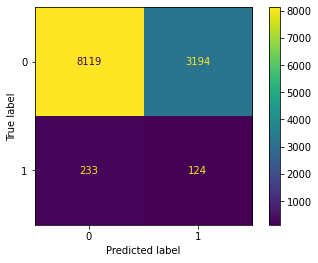

In [89]:
cm = confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [ ]:
import xgboost as xgb

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=4,stratify=y)

In [ ]:
from random import random
X_train=X_train.values.tolist()
X_test=X_test.values.tolist()
y_train=y_train.values.tolist()
y_test=y_test.values.tolist()
mask_y=[]
mask_x=[]
for i in range(len(X_train)):
    if y_train[i]==0 and random() <0.65:
        y_test.append(y_train[i])
        mask_y.append(i)
        X_test.append(X_train[i])
        mask_x.append(i)
for i in sorted(mask_y, reverse=True):
    y_train.pop(i)
for i in sorted(mask_x, reverse=True):
    X_train.pop(i)
X_train=pd.DataFrame(X_train)
X_test=pd.DataFrame(X_test)
y_train=pd.DataFrame(y_train)
y_test=pd.DataFrame(y_test)

In [ ]:
from sklearn.naive_bayes import GaussianNB
model_GNB = GaussianNB()

In [ ]:

model_GNB = xgb.XGBClassifier(random_state=13, n_jobs =4,silent =True)

## Tuning models

# Model Evaluation

# Model Improvement